In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install tensorflow keras matplotlib seaborn scikit-learn opencv-python pillow

# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.5 MB/s eta 0:00:00
TensorFlow version: 2.20.0
GPU Available: []


In [9]:
import os
import cv2
import numpy as np

def load_gesture_data(data_path, img_size=(64, 64)):
    """
    Load gesture images and their labels (handles nested folders)
    """
    images = []
    labels = []
    class_names = []

    # Get top-level class folders (00, 01, ...)
    for class_dir in sorted(os.listdir(data_path)):
        class_path = os.path.join(data_path, class_dir)
        if os.path.isdir(class_path):
            class_names.append(class_dir)
            print(f"Loading class: {class_dir}")

            # Walk through all subfolders recursively
            for root, _, files in os.walk(class_path):
                for img_file in files:
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(root, img_file)

                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, img_size)
                            img = img.astype(np.float32) / 255.0

                            images.append(img)
                            labels.append(class_dir)

    return np.array(images), np.array(labels), class_names

# Define the path to your dataset - **UPDATE THIS PATH**
dataset_path = '/content/drive/MyDrive/leapGestRecog' # Placeholder path

print("Loading gesture data...")
X, y, class_names = load_gesture_data(dataset_path)
print("Dataset loaded successfully!")
print(f"Total images: {len(X)}")
print(f"Image shape: {X[0].shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

Loading gesture data...
Loading class: 00
Loading class: 01
Loading class: 02
Loading class: 03
Loading class: 04
Loading class: 05
Loading class: 06
Loading class: 07
Loading class: 08
Loading class: 09
Dataset loaded successfully!
Total images: 20108
Image shape: (64, 64, 3)
Number of classes: 10
Classes: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


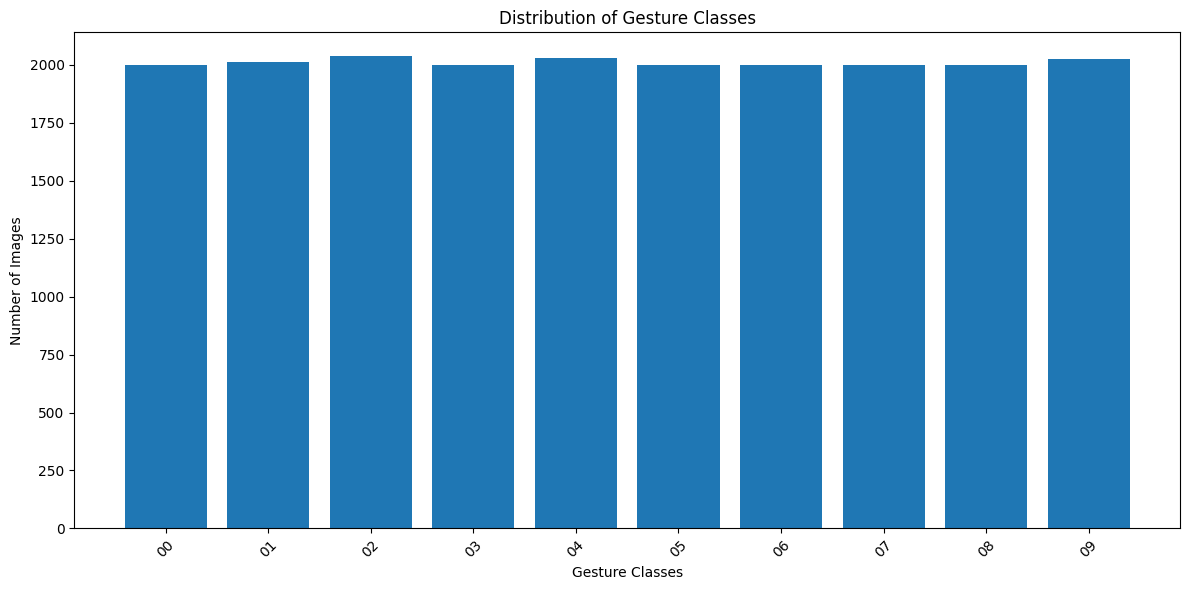

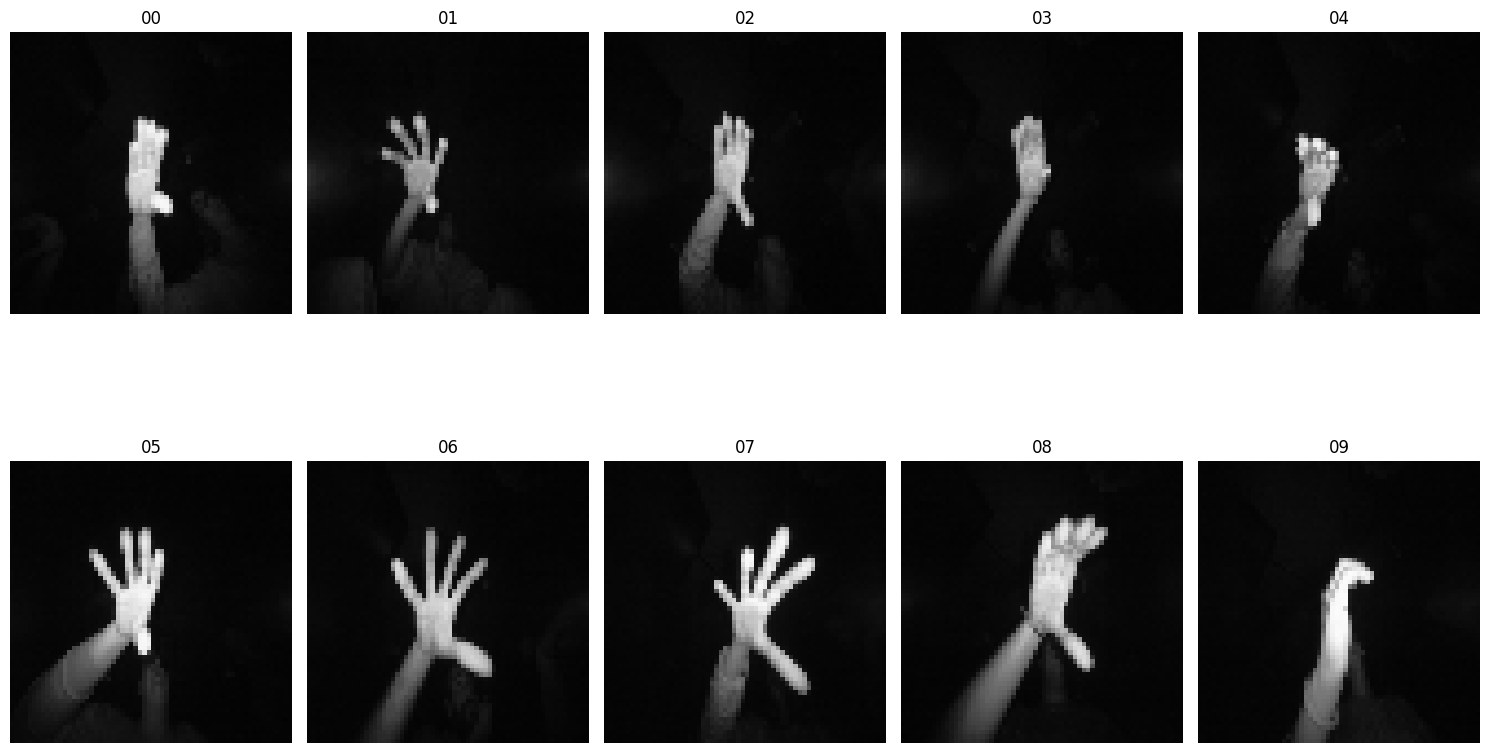

Shape of X: (20108, 64, 64, 3)
Shape of y: (20108,)


In [10]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(class_names)

# Display class distribution
unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))

plt.figure(figsize=(12, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Distribution of Gesture Classes')
plt.xlabel('Gesture Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display sample images from each class
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names[:10]):  # Show first 10 classes
    # Find first image of this class
    class_indices = np.where(y == class_name)[0]
    if len(class_indices) > 0:
        sample_img = X[class_indices[0]]
        plt.subplot(2, 5, i+1)
        plt.imshow(sample_img)
        plt.title(f'{class_name}')
        plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y_encoded.shape}")


In [11]:
# Convert labels to categorical
y_categorical = keras.utils.to_categorical(y_encoded, num_classes)

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test
val_datagen = ImageDataGenerator()


Training set: 14075 images
Validation set: 3016 images
Test set: 3017 images


In [12]:
def create_gesture_model(input_shape, num_classes):
    """
    Create a CNN model for gesture recognition
    """
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
input_shape = X_train.shape[1:]
model = create_gesture_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,052,106 (4.01 MB)

 Trainable params: 1,049,610 (4.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [13]:
# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        '/content/drive/MyDrive/best_gesture_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
print("Starting model training...")
batch_size = 32
epochs = 50

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Starting model training...
Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.1915 - loss: 2.8218
Epoch 1: val_accuracy improved from -inf to 0.10212, saving model to /content/drive/MyDrive/best_gesture_model.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 180s 402ms/step - accuracy: 0.1917 - loss: 2.8207 - val_accuracy: 0.1021 - val_loss: 8.3276 - learning_rate: 0.0010
Epoch 2/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 1:37 222ms/step - accuracy: 0.4375 - loss: 1.5204
Epoch 2: val_accuracy did not improve from 0.10212
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4375 - loss: 1.5204 - val_accuracy: 0.1021 - val_loss: 8.1961 - learning_rate: 0.0010
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.4977 - loss: 1.4014
Epoch 3: val_accuracy improved from 0.10212 to 0.65882, saving model to /content/drive/MyDrive/best_gesture_model.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 173s 395ms/step - accuracy: 0.4978 - loss: 1.4011 - val_accuracy: 0.6588 - val_loss: 0.8826 - learning_rate: 0.0010
Epoch 4/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 2:03 282ms/step - accuracy: 0.5938 - loss: 0.9176
Epoch 4: val_accuracy improved from 0.65882 to 0.67208, saving model to /content/drive/MyDrive/best_gesture_model.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5938 - loss: 0.9176 - val_accuracy: 0.6721 - val_loss: 0.8442 - learning_rate: 0.0010
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6540 - loss: 0.9509
Epoch 5: val_accuracy improved from 0.67208 to 0.72679, saving model to /content/drive/MyDrive/best_gesture_model.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 175s 398ms/step - accuracy: 0.6540 - loss: 0.9507 - val_accuracy: 0.7268 - val_loss: 0.7649 - learning_rate: 0.0010
Epoch 6/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 1:52 258ms/step - accuracy: 0.6250 - loss: 0.8355
Epoch 6: val_accuracy improved from 0.72679 to 0.73508, saving model to /content/drive/MyDrive/best_gesture_model.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6250 - loss: 0.8355 - val_accuracy: 0.7351 - val_loss: 0.7720 - learning_rate: 0.0010
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7570 - loss: 0.6662
Epoch 7: val_accuracy improved from 0.73508 to 0.76194, saving model to /content/drive/MyDrive/best_gesture_model.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 173s 395ms/step - accuracy: 0.7571 - loss: 0.6661 - val_accuracy: 0.7619 - val_loss: 0.6973 - learning_rate: 0.0010
Epoch 8/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 2:43 374ms/step - accuracy: 0.9062 - loss: 0.2255
Epoch 8: val_accuracy did not improve from 0.76194
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9062 - loss: 0.2255 - val_accuracy: 0.7530 - val_loss: 0.7341 - learning_rate: 0.0010
Epoch 9/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8150 - loss: 0.5091
Epoch 9: val_accuracy did not improve from 0.76194
439/439 ━━━━━━━━━━━━━━━━━━━━ 171s 390ms/step - accuracy: 0.8150 - loss: 0.5091 - val_accuracy: 0.6605 - val_loss: 0.8742 - learning_rate: 0.0010
Epoch 10/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 2:36 357ms/step - accuracy: 0.8438 - loss: 0.3176
Epoch 10: val_accuracy did not improve from 0.76194
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8438 - loss: 0.3176 - val_accuracy: 0.6615 - val_loss: 0.8783 - learning_rate: 0.0010
Epo

439/439 ━━━━━━━━━━━━━━━━━━━━ 170s 388ms/step - accuracy: 0.8819 - loss: 0.3340 - val_accuracy: 0.9108 - val_loss: 0.2190 - learning_rate: 5.0000e-04
Epoch 14/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 1:55 263ms/step - accuracy: 0.9375 - loss: 0.1534
Epoch 14: val_accuracy improved from 0.91081 to 0.91313, saving model to /content/drive/MyDrive/best_gesture_model.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9375 - loss: 0.1534 - val_accuracy: 0.9131 - val_loss: 0.2181 - learning_rate: 5.0000e-04
Epoch 15/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9025 - loss: 0.2721
Epoch 15: val_accuracy did not improve from 0.91313
439/439 ━━━━━━━━━━━━━━━━━━━━ 171s 389ms/step - accuracy: 0.9025 - loss: 0.2721 - val_accuracy: 0.8869 - val_loss: 0.2891 - learning_rate: 5.0000e-04
Epoch 16/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 1:59 273ms/step - accuracy: 0.9062 - loss: 0.2860
Epoch 16: val_accuracy did not improve from 0.91313
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9062 - loss: 0.2860 - val_accuracy: 0.8889 - val_loss: 0.2817 - learning_rate: 5.0000e-04
Epoch 17/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9172 - loss: 0.2272
Epoch 17: val_accuracy did not improve from 0.91313
439/439 ━━━━━━━━━━━━━━━━━━━━ 170s 387ms/step - accuracy: 0.9172 - loss: 0.2272 - val_accuracy: 0.7749 - val_loss: 0.7860 - learning_ra

439/439 ━━━━━━━━━━━━━━━━━━━━ 169s 385ms/step - accuracy: 0.9279 - loss: 0.1941 - val_accuracy: 0.9141 - val_loss: 0.1986 - learning_rate: 2.5000e-04
Epoch 22/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 1:40 230ms/step - accuracy: 0.9688 - loss: 0.0763
Epoch 22: val_accuracy did not improve from 0.91412
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9688 - loss: 0.0763 - val_accuracy: 0.9082 - val_loss: 0.2128 - learning_rate: 2.5000e-04
Epoch 23/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9401 - loss: 0.1598
Epoch 23: val_accuracy improved from 0.91412 to 0.96054, saving model to /content/drive/MyDrive/best_gesture_model.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 169s 385ms/step - accuracy: 0.9401 - loss: 0.1598 - val_accuracy: 0.9605 - val_loss: 0.0964 - learning_rate: 2.5000e-04
Epoch 24/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 2:01 278ms/step - accuracy: 0.9688 - loss: 0.0720
Epoch 24: val_accuracy did not improve from 0.96054
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9688 - loss: 0.0720 - val_accuracy: 0.9586 - val_loss: 0.0983 - learning_rate: 2.5000e-04
Epoch 25/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9444 - loss: 0.1508
Epoch 25: val_accuracy did not improve from 0.96054
439/439 ━━━━━━━━━━━━━━━━━━━━ 171s 389ms/step - accuracy: 0.9444 - loss: 0.1508 - val_accuracy: 0.8899 - val_loss: 0.2466 - learning_rate: 2.5000e-04
Epoch 26/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 2:43 374ms/step - accuracy: 0.9375 - loss: 0.1316
Epoch 26: val_accuracy did not improve from 0.96054
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9375 - loss: 0.1316 - val_accuracy: 0.8912 - val_loss: 0.2467 - learning_

439/439 ━━━━━━━━━━━━━━━━━━━━ 169s 386ms/step - accuracy: 0.9544 - loss: 0.1253 - val_accuracy: 0.9784 - val_loss: 0.0573 - learning_rate: 1.2500e-04
Epoch 32/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 1:38 224ms/step - accuracy: 0.9375 - loss: 0.1025
Epoch 32: val_accuracy did not improve from 0.97845
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9375 - loss: 0.1025 - val_accuracy: 0.9775 - val_loss: 0.0596 - learning_rate: 1.2500e-04
Epoch 33/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9556 - loss: 0.1238
Epoch 33: val_accuracy did not improve from 0.97845
439/439 ━━━━━━━━━━━━━━━━━━━━ 167s 382ms/step - accuracy: 0.9556 - loss: 0.1238 - val_accuracy: 0.9068 - val_loss: 0.2078 - learning_rate: 1.2500e-04
Epoch 34/50
  1/439 ━━━━━━━━━━━━━━━━━━━━ 1:57 267ms/step - accuracy: 1.0000 - loss: 0.0174
Epoch 34: val_accuracy did not improve from 0.97845
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 1.0000 - loss: 0.0174 - val_accuracy: 0.9065 - val_loss: 0.2079 - learning_

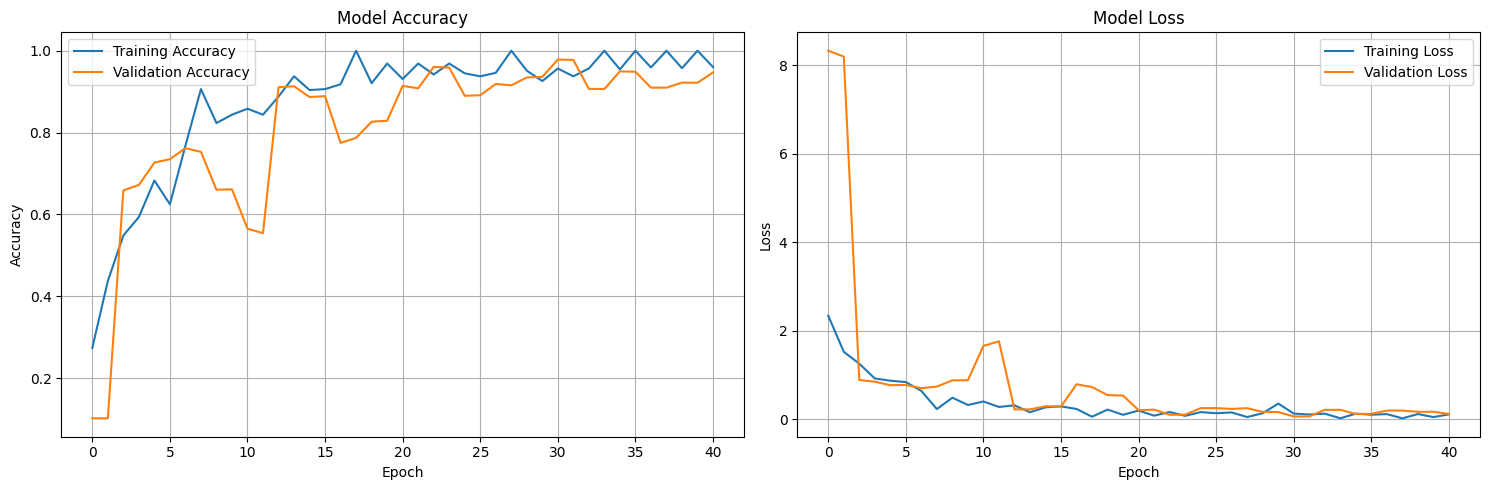

In [14]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation accuracy and loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


Test Accuracy: 0.9798
Test Loss: 0.0531
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step

Classification Report:
              precision    recall  f1-score   support

          00       1.00      1.00      1.00       300
          01       1.00      1.00      1.00       301
          02       1.00      0.91      0.95       306
          03       1.00      1.00      1.00       300
          04       0.98      0.94      0.96       305
          05       0.92      1.00      0.96       300
          06       1.00      0.96      0.98       300
          07       0.93      1.00      0.96       300
          08       1.00      0.99      0.99       300
          09       0.99      1.00      1.00       305

    accuracy                           0.98      3017
   macro avg       0.98      0.98      0.98      3017
weighted avg       0.98      0.98      0.98      3017



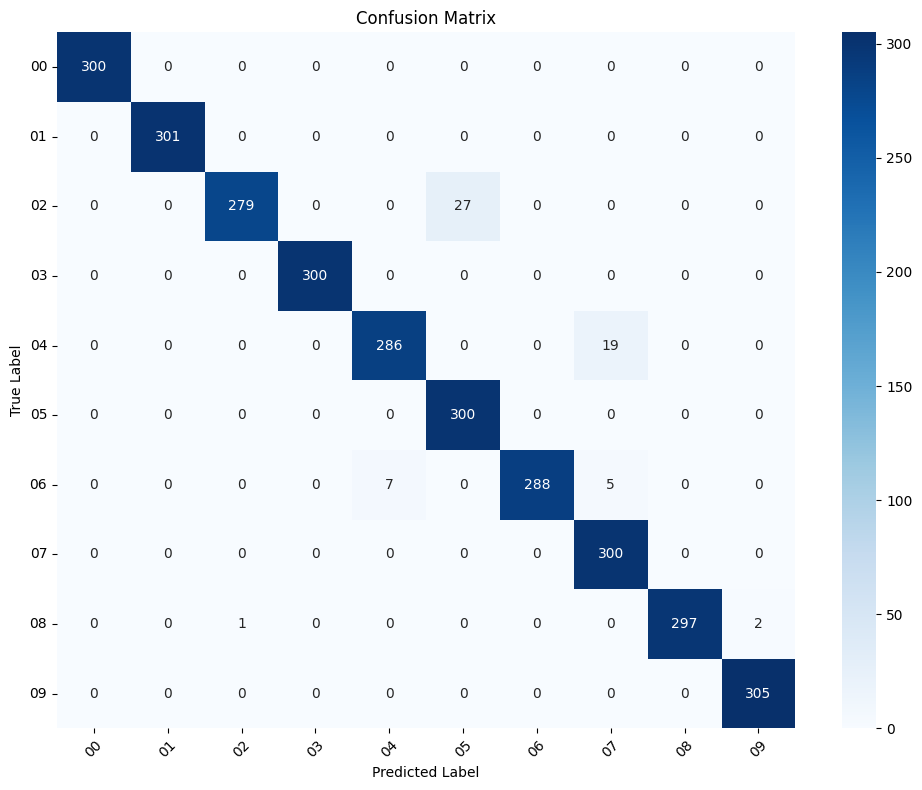

In [15]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


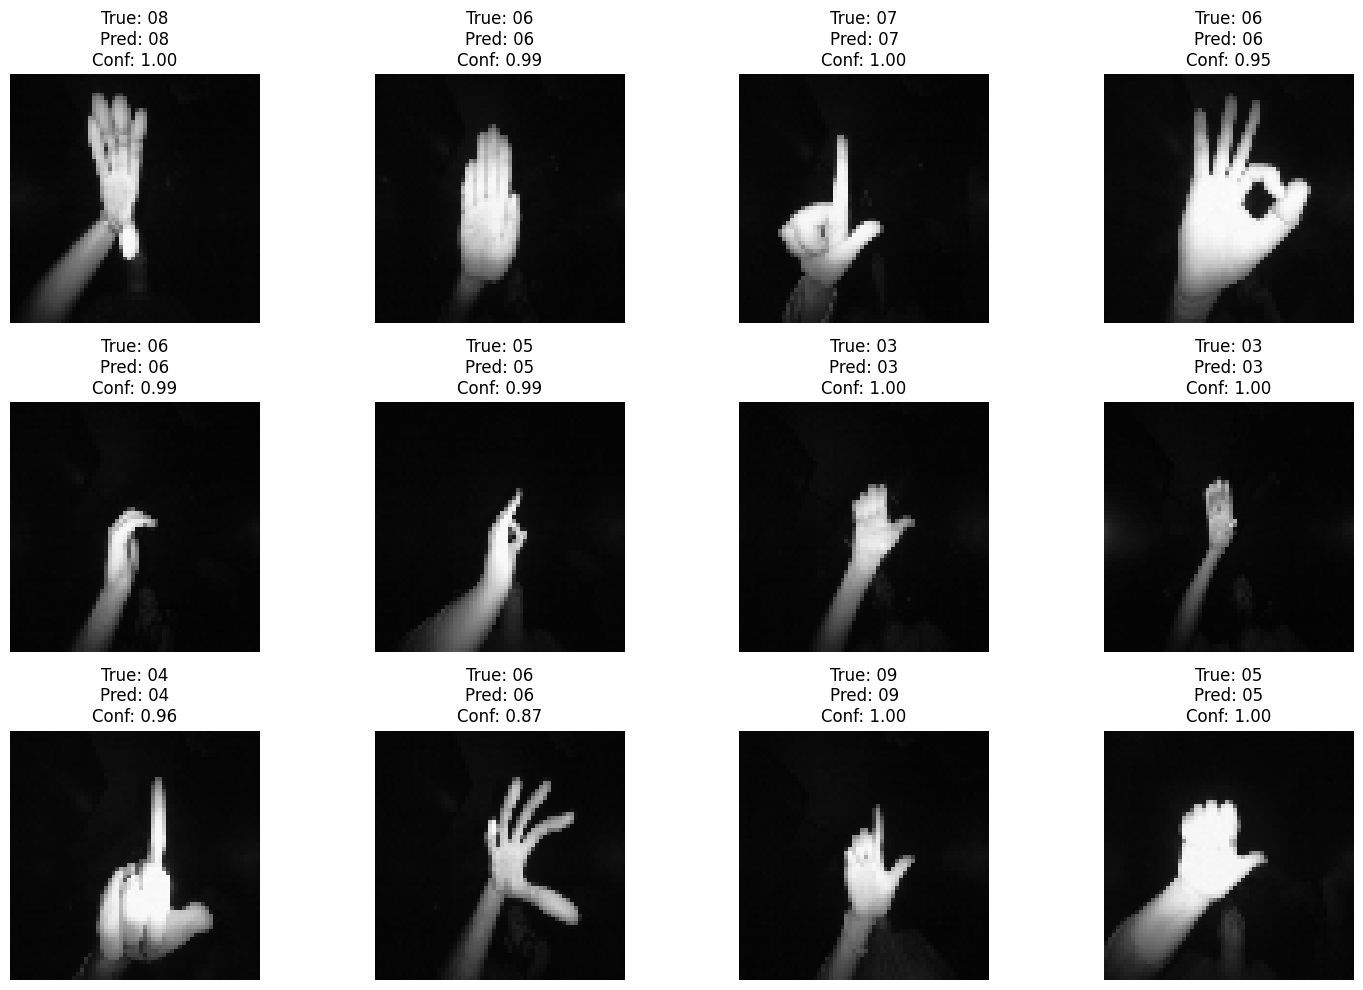

In [16]:
def predict_gesture(model, image_path, class_names, img_size=(64, 64)):
    """
    Predict gesture from a single image
    """
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img)
    predicted_class_idx = np.argmax(prediction)
    confidence = prediction[0][predicted_class_idx]

    return class_names[predicted_class_idx], confidence

# Test on some random images from test set
plt.figure(figsize=(15, 10))
for i in range(12):
    idx = np.random.randint(0, len(X_test))

    # Get prediction
    img = np.expand_dims(X_test[idx], axis=0)
    prediction = model.predict(img, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    confidence = prediction[0][predicted_class_idx]
    true_class_idx = np.argmax(y_test[idx])

    # Plot
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test[idx])
    plt.title(f'True: {class_names[true_class_idx]}\n'
              f'Pred: {class_names[predicted_class_idx]}\n'
              f'Conf: {confidence:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
# Save the final model
model_save_path = '/content/drive/MyDrive/gesture_recognition_model.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# Save class names
import pickle
with open('/content/drive/MyDrive/class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)
print("Class names saved!")

# Function to load the model later
def load_trained_model(model_path, class_names_path):
    """Load the trained model and class names"""
    model = keras.models.load_model(model_path)
    with open(class_names_path, 'rb') as f:
        class_names = pickle.load(f)
    return model, class_names

# Example of loading (run this in a new session)
# model, class_names = load_trained_model(
#     '/content/drive/MyDrive/gesture_recognition_model.h5',
#     '/content/drive/MyDrive/class_names.pkl'
# )


Model saved to: /content/drive/MyDrive/gesture_recognition_model.h5
Class names saved!


In [18]:
def create_gesture_predictor():
    """
    Create a function for real-time gesture prediction
    """
    # Load model and class names
    model = keras.models.load_model('/content/drive/MyDrive/gesture_recognition_model.h5')
    with open('/content/drive/MyDrive/class_names.pkl', 'rb') as f:
        class_names = pickle.load(f)

    def predict_gesture_from_array(image_array):
        """
        Predict gesture from numpy array
        """
        # Preprocess
        if len(image_array.shape) == 3:
            image_array = np.expand_dims(image_array, axis=0)

        # Predict
        prediction = model.predict(image_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        confidence = prediction[0][predicted_class_idx]

        return {
            'gesture': class_names[predicted_class_idx],
            'confidence': float(confidence),
            'all_predictions': {
                class_names[i]: float(prediction[0][i])
                for i in range(len(class_names))
            }
        }

    return predict_gesture_from_array

# Create predictor function
predictor = create_gesture_predictor()

# Test the predictor
test_image = X_test[0:1]  # Take one test image
result = predictor(test_image)
print("Prediction Result:")
print(f"Gesture: {result['gesture']}")
print(f"Confidence: {result['confidence']:.4f}")
print("All predictions:")
for gesture, conf in result['all_predictions'].items():
    print(f"  {gesture}: {conf:.4f}")


Prediction Result:
Gesture: 00
Confidence: 1.0000
All predictions:
  00: 1.0000
  01: 0.0000
  02: 0.0000
  03: 0.0000
  04: 0.0000
  05: 0.0000
  06: 0.0000
  07: 0.0000
  08: 0.0000
  09: 0.0000
